<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebooks/9th_August_Sliding_Window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1️⃣ Setup Notebook 💻**


### **Authenticate with BigQuery ☁️**

In [ ]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]
!pip install --upgrade pandas-gbq

In [ ]:
import google.auth
from google.colab import auth
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta1

auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
credentials, your_project_id = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
your_project_id = 'machine-learning-msc'
# Make clients.
bqclient = bigquery.Client(
    credentials=credentials,
    project=your_project_id
    )
bqstorageclient = bigquery_storage_v1beta1.BigQueryStorageClient(
    credentials=credentials
)

In [ ]:
query_string = """
SELECT
COUNT(*) AS test
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 
"""

In [ ]:
def download_query_results(query_string, bqclient=bqclient, bqstorateclient=bqstorageclient):
    df = bqclient.query(query_string).result().to_dataframe(bqstorage_client=bqstorageclient)
    return df

In [ ]:
df = download_query_results(query_string, bqclient, bqstorageclient)
df

,test
0,14841792


In [ ]:
import pandas_gbq
def output_to_bq(forecast, table_id, project_id='machine-learning-msc'):
    pandas_gbq.to_gbq(forecast, table_id, project_id=project_id, if_exists='append')

### **Importing Libraries⏬**

##### Standard Libraries

In [ ]:
!pip install fbprophet
!pip install MiniSom

  Created wheel for MiniSom: filename=MiniSom-2.2.6-cp36-none-any.whl size=8525 sha256=bc76b008dba79ba430bd8ac09f68a554700e77f54b72e4a636b2a2ea3507d19f
  Stored in directory: /root/.cache/pip/wheels/b8/c6/01/330066e36e1f7c826c96f656f9185822cfcdef0591315949ea
Successfully built MiniSom


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import datetime as dt

from minisom import MiniSom
from tqdm import tqdm
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
 
sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas_gbq
def output_to_bq(forecast, table_id, project_id='machine-learning-msc'):
    pandas_gbq.to_gbq(forecast, table_id, project_id=project_id, if_exists='append')

##### Import Github Repository

In [ ]:
%cd /content
!rm -rf mscproj
!git clone https://github.com/shengy90/MSc-Project mscproj
!git pull
%cd /content/mscproj/
!ls

/content
Cloning into 'mscproj'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 526 (delta 106), reused 105 (delta 55), pack-reused 361
Receiving objects: 100% (526/526), 12.73 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (304/304), done.
fatal: not a git repository (or any of the parent directories): .git
/content/mscproj
bin	     __init__.py  notebooks  requirements.txt  sql
definitions  Makefile	  README.md  run.py	       src


In [ ]:
%reload_ext autoreload 
%autoreload 2 
from src.train_prophet import TrainProphet
from src.train_clusters import TrainClusters
from src.train_clusters import Normaliser
from src.train_sliding_window import train_som, train_baseline, train_som_forecasts, evaluate_results, generate_query_strings

# **2️⃣ Sliding Window Protocol**

## **Create Sliding Window Protocol**

### Functions

In [ ]:
def save_results(df, train_test_split, model_name, num_clusters, start_date, end_date, eval_date, model_date):
    save_df = df.copy()
    save_df['model_date'] = model_date
    save_df['start_date'] = start_date
    save_df['end_date'] = end_date
    save_df['eval_date'] = eval_date             
    save_df['model'] = model_name
    save_df['train_test_split'] = train_test_split
    save_df['num_clusters'] = num_clusters
    output_to_bq(save_df, 'sliding_window.results')

In [ ]:
def train_forecast(start_date, num_clusters=None, upload_to_bq=False):

    num_clusters = 5 if num_clusters==None else num_clusters
    print(f"Number of clusters: {num_clusters}")

    start_date = datetime.strptime(start_date, "%Y-%m-%d").date()

    end_date = start_date + relativedelta(months=4)
    eval_date = start_date + relativedelta(months=3)
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    eval_date = eval_date.strftime("%Y-%m-%d")
    som_query_string, ts_query_string= generate_query_strings(start_date, end_date)

    print(f"\nDownloading data for periods: {start_date} -> {end_date}")
    som_df = download_query_results(som_query_string, bqclient, bqstorageclient)
    ts_df = download_query_results(ts_query_string, bqclient, bqstorageclient)
    ts_df['ds'] = ts_df['ds'].dt.tz_localize(None)
    
    print(f"Training SOM Clusters.....")
    som_clusters = train_som(som_df, num_clusters)
    print(f"Training Baseline Model.....")
    baseline_model = train_baseline(ts_df, som_clusters, eval_date)
    print(f"Training SOM Forecasts.....")
    som_model, som_train_global, som_test_global = train_som_forecasts(ts_df, som_clusters, eval_date)
    
    print(f"\nEvaluating Baseline...")
    evaluate_results(baseline_model.train_global, baseline_model.test_global)
    print(f"\nEvaluating SOM...")
    evaluate_results(som_train_global, som_test_global)


    num_clusters = 5 if num_clusters==None else num_clusters
    today = datetime.now().date().strftime('%Y-%m-%d')
    
    if upload_to_bq == True:
        print(f"Uploading results to BigQuery...")
        save_results(baseline_model.train_global, "train", "baseline", 1, start_date, end_date, eval_date, today)
        save_results(baseline_model.test_global, "test", "baseline", 1, start_date, end_date, eval_date, today)
        save_results(som_train_global, "train", "som_clusters", num_clusters, start_date, end_date, eval_date, today)
        save_results(som_test_global, "test", "som_clusters", num_clusters, start_date, end_date, eval_date, today)

    print(f"\nFinished Training and Evaluation for periods: {start_date} -> {end_date}!\n")
    print("--------------------------------------------------------------------------------")
    return som_clusters, baseline_model, som_train_global, som_test_global

### Forecasts

In [ ]:
start_dates = ['2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01']

for start_date in start_dates:
    som_clusters, baseline_model, som_train_global, som_test_global = train_forecast(start_date)


Training SOM Clusters.....
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 19.8415756779928
Training Baseline Model.....
Training SOM Forecasts.....

Evaluating Baseline...
Train global MAPE: 7.4399999999999995. Test global MAPE: 8.88.

Evaluating SOM...
Train global MAPE: 7.42. Test global MAPE: 7.55.
Uploading results to BigQuery...



1344 out of 1344 rows loaded.
1it [00:02,  2.28s/it]

1344 out of 1344 rows loaded.
1it [00:02,  2.95s/it]

6720 out of 6720 rows loaded.

1it [00:03,  3.56s/it]

6720 out of 6720 rows loaded.

1it [00:02,  2.33s/it]



Finished Training and Evaluation for periods: 2012-11-01 -> 2013-03-01!

--------------------------------------------------------------------------------

Training SOM Clusters.....
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 19.75592700883923
Training Baseline Model.....
Training SOM Forecasts.....



1488 out of 1488 rows loaded.



Evaluating Baseline...
Train global MAPE: 8.290000000000001. Test global MAPE: 9.120000000000001.

Evaluating SOM...
Train global MAPE: 8.44. Test global MAPE: 8.07.
Uploading results to BigQuery...


1it [00:02,  2.42s/it]

1488 out of 1488 rows loaded.
1it [00:02,  2.44s/it]

7440 out of 7440 rows loaded.

1it [00:02,  2.91s/it]

7440 out of 7440 rows loaded.

1it [00:04,  4.32s/it]



Finished Training and Evaluation for periods: 2012-12-01 -> 2013-04-01!

--------------------------------------------------------------------------------

Training SOM Clusters.....
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 20.26105510270428
Training Baseline Model.....
Training SOM Forecasts.....



1440 out of 1440 rows loaded.



Evaluating Baseline...
Train global MAPE: 13.669999999999998. Test global MAPE: 13.020000000000001.

Evaluating SOM...
Train global MAPE: 14.04. Test global MAPE: 12.75.
Uploading results to BigQuery...


1it [00:02,  2.94s/it]

1440 out of 1440 rows loaded.
1it [00:02,  2.74s/it]

7200 out of 7200 rows loaded.

1it [00:03,  3.70s/it]

7200 out of 7200 rows loaded.

1it [00:03,  3.92s/it]



Finished Training and Evaluation for periods: 2013-01-01 -> 2013-05-01!

--------------------------------------------------------------------------------

Training SOM Clusters.....
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 21.25172153350484
Training Baseline Model.....
Training SOM Forecasts.....



1488 out of 1488 rows loaded.



Evaluating Baseline...
Train global MAPE: 16.939999999999998. Test global MAPE: 17.65.

Evaluating SOM...
Train global MAPE: 19.259999999999998. Test global MAPE: 21.18.
Uploading results to BigQuery...


1it [00:01,  1.96s/it]

1488 out of 1488 rows loaded.
1it [00:05,  5.06s/it]

7440 out of 7440 rows loaded.

1it [00:04,  4.54s/it]

7440 out of 7440 rows loaded.

1it [00:02,  2.66s/it]


Finished Training and Evaluation for periods: 2013-02-01 -> 2013-06-01!

--------------------------------------------------------------------------------


# 3️⃣ **Evaluating Sliding Window Performance**

##### **Get Sliding Window Results from BQ**

In [ ]:
%%bigquery --project machine-learning-msc df_results --use_bqstorage_api
WITH stg1 AS (
SELECT 
CAST(TIMESTAMP_TRUNC(ds, MONTH) AS DATE) AS month,
* EXCEPT(cluster),
CAST(IF(model = 'baseline', 1, cluster) AS STRING) AS cluster
FROM `machine-learning-msc.sliding_window.results`
WHERE model_date = '2020-08-09' AND num_clusters = 5
)

SELECT 
*,
ROW_NUMBER() OVER (PARTITION BY model, train_test_split, cluster ORDER BY ds ASC) AS row_num
FROM stg1
ORDER BY model, train_test_split, cluster, ds ASC

In [ ]:
df_results['ds'] = df_results['ds'].dt.tz_localize(None) # remove timezones 

df_baseline_train = df_results.query("model=='baseline' and train_test_split=='train'").copy()
df_baseline_test = df_results.query("model=='baseline' and train_test_split=='test'").copy()
df_som_train = df_results.query("model=='som_clusters' and train_test_split=='train'").copy()
df_som_test = df_results.query("model=='som_clusters' and train_test_split=='test'").copy()

In [ ]:
def _agg_results(df, monthly):
    if monthly==True:
        aggcol = 'month'
    else:
        aggcol = 'ds'

    agg = df.groupby(aggcol).sum()
    agg.reset_index(inplace=True)
    agg = agg[[aggcol, 'y_global', 'yhat_global']]
    agg['abs_perc_err'] = np.round(np.abs(agg['yhat_global']/agg['y_global']-1),6)*100
    return agg

def evaluate_forecast(df, monthly=None):
    forecasts = _agg_results(df, monthly)

    if monthly is None:
        print(f"Global Mean Average Percentage Error: {np.mean(forecasts['abs_perc_err'])}")
    results = forecasts
    return results

In [ ]:
def combine_results(idx_name, df1, df2, df1_name, df2_name, first=None):
    if first == True:
        df1 = df1[[idx_name, 'abs_perc_err']].copy()
        df1.rename(columns={'abs_perc_err':f"{df1_name}_APE"}, inplace=True)
    df2 = df2[[idx_name, 'abs_perc_err']].copy()
    df2.rename(columns={'abs_perc_err':f"{df2_name}_APE"}, inplace=True)

    out_df = df1.merge(df2, left_on=idx_name, right_on=idx_name)
    return out_df

In [ ]:
print("\nBaseline Train:")
x = evaluate_forecast(df_baseline_train)
print("\nBaseline Test:")
x = evaluate_forecast(df_baseline_test)
print("\nSOM Train:")
x = evaluate_forecast(df_som_train)
print("\nSOM Test:")
x = evaluate_forecast(df_som_test)


Baseline Train:
Global Mean Average Percentage Error: 9.575817505447196

Baseline Test:
Global Mean Average Percentage Error: 9.952238428017255

SOM Train:
Global Mean Average Percentage Error: 9.840680544188736

SOM Test:
Global Mean Average Percentage Error: 9.936238656533986


In [ ]:
basetrain = evaluate_forecast(df_baseline_train, monthly=True)
basetest = evaluate_forecast(df_baseline_test, monthly=True)
somtrain = evaluate_forecast(df_som_train, monthly=True)
somtest = evaluate_forecast(df_som_test, monthly=True)

In [ ]:
monthly_ape = combine_results('month', basetrain, basetest, 'base_train', 'base_test', first=True)
monthly_ape = combine_results('month', monthly_ape, somtrain, None, 'som_train')
monthly_ape = combine_results('month', monthly_ape, somtest, None, 'som_test')

In [ ]:
monthly_ape

,month,base_train_APE,base_test_APE,som_train_APE,som_test_APE
0,2013-02-01,2.0544,1.5996,1.9770,0.1182
1,2013-03-01,3.7710,3.4763,4.2418,2.7302
2,2013-04-01,7.4952,5.9928,7.9079,5.5975
3,2013-05-01,15.7664,16.3137,17.4087,19.4474
4,2013-06-01,1.1297,0.7920,0.6504,0.0097
5,2013-07-01,3.7439,4.1796,4.1148,6.0481
6,2013-08-01,0.6945,0.1291,0.3574,0.4330
7,2013-09-01,5.7219,5.9296,5.7095,5.7272
8,2013-10-01,6.1696,5.7002,5.9388,5.5161
9,2013-11-01,8.4111,8.5694,8.1120,8.7072


# 4️⃣  **Trying different cluster sizes for Evaluation Periods: May, July and Dec 2013**

### **Training Clusters 2->13**

In [ ]:
clusters = [11,12,13]

for cluster in clusters:
    a, b, c, d = train_forecast('2013-02-01', num_clusters=cluster, upload_to_bq=True)
    a, b, c, d = train_forecast('2013-04-01', num_clusters=cluster, upload_to_bq=True)
    a, b, c, d = train_forecast('2013-09-01', num_clusters=cluster, upload_to_bq=True)

### **Evaluating Clusters**

In [ ]:
%%bigquery --project machine-learning-msc df_results --use_bqstorage_api
WITH stg1 AS (
SELECT 
CAST(TIMESTAMP_TRUNC(ds, MONTH) AS DATE) AS month,
* EXCEPT(cluster),
CAST(IF(model = 'baseline', 1, cluster) AS STRING) AS cluster
FROM `machine-learning-msc.sliding_window.results`
WHERE model_date = '2020-08-11' 
)

SELECT 
DISTINCT 
*
FROM stg1
ORDER BY model, train_test_split, cluster, ds ASC

In [ ]:
df_results['ds'] = df_results['ds'].dt.tz_localize(None) # remove timezones 
df_baseline_train = df_results.query("model=='baseline' and train_test_split=='train'").copy()
df_baseline_test = df_results.query("model=='baseline' and train_test_split=='test'").copy()
df_som_train = df_results.query("model=='som_clusters' and train_test_split=='train'").copy()
df_som_test = df_results.query("model=='som_clusters' and train_test_split=='test'").copy()

In [ ]:
def evaluate_cluster_results(df, baseline=False):
    months_list = df['eval_date'].unique().tolist()
    num_cluster_list = df['num_clusters'].unique().tolist()

    eval_results = pd.DataFrame()
    for month in months_list:
        for cluster_num in num_cluster_list:
            eval_df = df.query(f"num_clusters=={cluster_num} and eval_date=='{month}'").copy()
            results = evaluate_forecast(eval_df, monthly=True)
            results['number_of_clusters'] = cluster_num
            results['month'] = results['month'].astype(str)
            eval_results = pd.concat([eval_results, results])

    return eval_results

In [ ]:
som_test_results = evaluate_cluster_results(df_som_test)
som_train_results = evaluate_cluster_results(df_som_train)
baseline_test_results = evaluate_cluster_results(df_baseline_test)
baseline_train_results = evaluate_cluster_results(df_baseline_train)

In [ ]:
def get_cluster_results(train_df, test_df, base_train_df, base_test_df, monthstr):
    a = train_df.query(f"month=='{monthstr}'").copy()
    a.rename(columns={'abs_perc_err':'train_mape'}, inplace=True)

    b = test_df.query(f"month=='{monthstr}'").copy()
    b.rename(columns={'abs_perc_err':'test_mape'}, inplace=True)

    out_df = a[['number_of_clusters','train_mape']].merge(b[['number_of_clusters','test_mape']], on='number_of_clusters')
    out_df.sort_values(by='number_of_clusters', inplace=True)
    
    base_train_results = base_train_df.query(f"month=='{monthstr}'")['abs_perc_err'].values[0]
    base_test_results = base_test_df.query(f"month=='{monthstr}'")['abs_perc_err'].values[0]
    print(f"Baseline Train MAPE: {base_train_results}.\nBaseline Test MAPE: {base_test_results}.")

    plt.title(f"Evaluation Period: {monthstr}")
    sns.lineplot(data=out_df, x='number_of_clusters', y='train_mape', label='Training MAPE', marker='o')
    sns.lineplot(data=out_df, x='number_of_clusters', y='test_mape', label='Test MAPE', marker='o')
    
    return out_df

Baseline Train MAPE: 15.766399999999999.
Baseline Test MAPE: 16.3137.


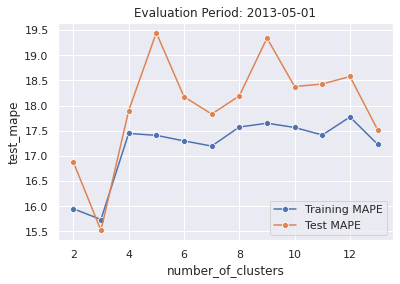

In [ ]:
df_may2013 = get_cluster_results(train_df=som_train_results, 
                                 test_df=som_test_results, 
                                 base_train_df = baseline_train_results,
                                 base_test_df = baseline_test_results, 
                                 monthstr="2013-05-01")

Baseline Train MAPE: 3.7439.
Baseline Test MAPE: 4.1796.


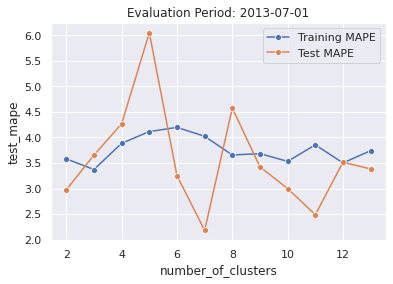

In [ ]:
df_jul2013 = get_cluster_results(train_df=som_train_results, 
                                 test_df=som_test_results, 
                                 base_train_df = baseline_train_results,
                                 base_test_df = baseline_test_results, 
                                 monthstr="2013-07-01")

Baseline Train MAPE: 5.333600000000001.
Baseline Test MAPE: 4.359500000000001.


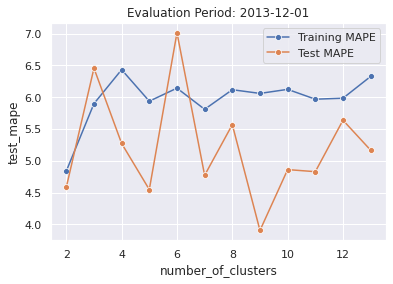

In [ ]:
df_dec2013 = get_cluster_results(train_df=som_train_results, 
                                 test_df=som_test_results, 
                                 base_train_df = baseline_train_results,
                                 base_test_df = baseline_test_results, 
                                 monthstr="2013-12-01")